# Recognizing Traffic signs using ConvNets
The dataset we will use is part of a competition named **German Traffic Sign Recognition Benchmark ( GTSRB )**, which attempted to score the performance of multiple models for the same goal.

## Image Preprocessing
The first operation of the model is reading the images and standardizing them. In fact, we cannot work with images of variable sizes; therefore, in this first step, we'll load the images and reshape them to a predefined size (32x32). Moreover, we will one-hot encode the labels in order to have a 43-dimensional array where only one element is enabled (it contains a 1), and we will convert the color space of the images from RGB to grayscale.

In [1]:
N_Classes = 43
Resized_image = (32,32)

In [2]:
# function to read images, resize to predefined shape, and convert them to greyscale, encode labels.
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
np.random.seed(101)
%matplotlib inline
Dataset = namedtuple('Dataset',['X','Y'])
def to_tf_format(imgs):
    # stacking images over each other.
  return np.stack([img[:,:,np.newaxis] for img in imgs], axis=0).astype(np.float32)
def read_dataset_ppm(rootpath, n_labels, resize_to):
  images = []
  labels = []
  for c in range(n_labels):
    full_path = rootpath + '/' + format(c, '05d') + '/'# defining full path of individual image folders.
    for img_name in glob.glob(full_path + "*.ppm"):
      # rgb to lab conversion.
      img = plt.imread(img_name).astype(np.float32)#converting image to a matrix.
      img = rgb2lab(img / 255.0)[:,:,0]
      if resize_to:# resizing the image into desired size.
        img = resize(img, resize_to, mode = 'reflect')
        #one-hot encoding.
      label = np.zeros((n_labels, ), dtype=np.float32)
      label[c] = 1.0
      images.append(img.astype(np.float32))
      labels.append(label)
  return Dataset(X = to_tf_format(images).astype(np.float32), Y = np.matrix(labels).astype(np.float32))
dataset = read_dataset_ppm('/home/aniket/Documents/Traffic signals/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images', N_Classes, Resized_image)
print(dataset.X.shape)
print(dataset.Y.shape)

(39209, 32, 32, 1)
(39209, 43)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


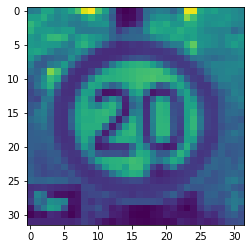

In [3]:
plt.imshow(dataset.X[0,:,:,:].reshape(Resized_image))
print(dataset.Y[0, :])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


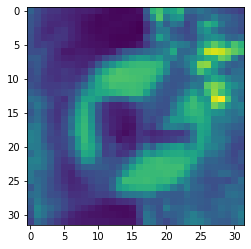

In [4]:
plt.imshow(dataset.X[-1,:,:,:].reshape(Resized_image))
print(dataset.Y[-1, :])

In [5]:
# train-test split
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size = 0.25, random_state = 101)
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
Y_train = dataset.Y[idx_train,:]
Y_test = dataset.Y[idx_test, :]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


## Train the model and make predictions

In [6]:
# minibatch generator.
def minibatcher(X, y, batch_size, shuffle):
    assert X.shape[0] == y.shape[0]# checking whether number of X and y are same are not.
    n_samples = X.shape[0]
    if shuffle:
        idx = np.random.permutation(n_samples)
    else:
        idx = list(range(n_samples))
    for k in range(int(np.ceil(n_samples/batch_size))):
        from_idx = k*batch_size
        to_idx = (k+1)*batch_size
        yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]

In [7]:
# batch_size = 10000
for mb in minibatcher(X_train, Y_train, 10000, True):
    print(mb[0].shape, mb[1].shape)

(10000, 32, 32, 1) (10000, 43)
(10000, 32, 32, 1) (10000, 43)
(9406, 32, 32, 1) (9406, 43)


We will use Xavier initialization for the coefficients(weights) and 0-initilization for the biases to have the layer centered and scaled properly. The output is simply the multiplication of the input tensor by the weights, plus the bias.

In [8]:
# fully connected layers without activation layers.
import tensorflow as tf
import tf_slim as slim
def fc_no_activation_layer(in_tensors, n_units):
    w = tf.compat.v1.get_variable('fc_W', [in_tensors.get_shape()[1], n_units], tf.float32, tf.keras.initializers.GlorotUniform())
    b = tf.compat.v1.get_variable('fc_B', [n_units, ], tf.float32, tf.constant_initializer(0.0))
    return tf.matmul(in_tensors, w) + b

2022-08-30 10:28:51.513327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-30 10:28:51.513366: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# fully connected layers with activation layers(Leaky ReLU).
def fc_layer(in_tensors, n_units):
    return tf.nn.leaky_relu(fc_no_activation_layer(in_tensors, n_units))

In [10]:
# convolutional layers with Leaky ReLU activations.
def conv_layer(in_tensors, kernel_size, n_units):
    w = tf.compat.v1.get_variable('conv_W', [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units], tf.float32, tf.keras.initializers.GlorotUniform())
    b = tf.compat.v1.get_variable('conv_B', [n_units, ], tf.float32, tf.constant_initializer(0.0))
    return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w, [1, 1, 1, 1], 'SAME') + b) 

In [11]:
# MAXPOOL layer
def maxpool_layer(in_tensors, sampling):
    return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1], [1, sampling, sampling, 1], 'SAME')

In [12]:
# dropout for regularizing the network
def dropout(in_tensors, keep_proba, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba), lambda: in_tensors)

In [13]:
# putting all together and creating the model.
def model(in_tensors, is_training):
    # First layer: 5x5 2d-conv, 32 filters, 2x maxpool, 20% dropout
    with tf.compat.v1.variable_scope('l1'):
        l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
        l1_out = dropout(l1, 0.7, is_training)
    # Second layer: 5x5 2d_conv, 64 filters, 2x maxpool, 20% dropout
    with tf.compat.v1.variable_scope('l2'):
        l2 = maxpool_layer(conv_layer(l1_out, 5, 64), 2)
        l2_out = dropout(l2, 0.7, is_training)
    with tf.compat.v1.variable_scope('flatten'):
        l2_out_flat = tf.compat.v1.layers.flatten(l2_out)
    # Fully collection layer, 1024 neurons, 40% dropout
    with tf.compat.v1.variable_scope('l3'):
        l3 = fc_layer(l2_out_flat, 1024)
        l3_out = dropout(l3, 0.6, is_training)
    # output
    with tf.compat.v1.variable_scope('out'):
        out_tensors = fc_no_activation_layer(l3_out, N_Classes)
    return out_tensors

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
def train_model(X_train, Y_train, X_test, Y_test, learning_rate, max_epochs, batch_size):
    in_X_tensors_batch = tf.compat.v1.placeholder(tf.float32, shape = (None, Resized_image[0], Resized_image[1], 1))
    in_Y_tensors_batch = tf.compat.v1.placeholder(tf.float32, shape = (None, N_Classes))
    is_training = tf.compat.v1.placeholder(tf.bool)
    logits = model(in_X_tensors_batch, is_training)
    out_y_pred = tf.nn.softmax(logits)
    loss_score = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=in_Y_tensors_batch)
    loss = tf.reduce_mean(loss_score)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)
    with tf.compat.v1.Session() as session:
        session.run(tf.compat.v1.global_variables_initializer())
        for epoch in range(max_epochs):
            print("Epoch=", epoch)
            tf_score = []
            for mb in minibatcher(X_train, Y_train, batch_size, shuffle = True):
                tf_output = session.run([optimizer, loss], feed_dict = {in_X_tensors_batch : mb[0],in_Y_tensors_batch : mb[1], is_training :True})
                tf_score.append(tf_output[1])
            print("train_loss_score = ", np.mean(tf_score))
        print("TEST SET PERFORMANCE")
        y_test_pred, test_loss = session.run([out_y_pred, loss], feed_dict = {in_X_tensors_batch: X_test, in_Y_tensors_batch : Y_test, is_training:False})
        print("test_loss_score = ", test_loss)
        y_test_pred_classified = np.argmax(y_test_pred, axis = 1).astype(np.int32)
        y_test_true_classified = np.argmax(Y_test, axis = 1).astype(np.int32)
        print(classification_report(y_test_true_classified, y_test_pred_classified))
        cm = confusion_matrix(y_test_true_classified, y_test_pred_classified)
        plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        # and the log2 version, to emphasize the misclassifications
        plt.imshow(np.log2(cm-1), interpolation = 'nearest', cmap = plt.get_cmap("tab20"))
        plt.colorbar()
        plt.tight_layout()
        plt.show()
tf.compat.v1.reset_default_graph()

2022-08-30 10:29:05.157039: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-30 10:29:05.157071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aniket-IdeaPad-Gaming3-15ARH05D): /proc/driver/nvidia/version does not exist
/tmp/ipykernel_5169/2822115002.py:12: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  l2_out_flat = tf.compat.v1.layers.flatten(l2_out)
/home/aniket/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-08-30 10:29:05.815536: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Libr

Epoch= 0
train_loss_score =  7.074169
Epoch= 1
train_loss_score =  2.5416887
Epoch= 2
train_loss_score =  1.7091126
Epoch= 3
train_loss_score =  1.2758688
Epoch= 4
train_loss_score =  1.0289983
Epoch= 5
train_loss_score =  0.85809284
Epoch= 6
train_loss_score =  0.76316416
Epoch= 7
train_loss_score =  0.6960726
Epoch= 8
train_loss_score =  0.6294694
Epoch= 9
train_loss_score =  0.585193
TEST SET PERFORMANCE


2022-08-30 10:34:06.663760: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1284898816 exceeds 10% of free system memory.
2022-08-30 10:34:07.368159: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 321224704 exceeds 10% of free system memory.
2022-08-30 10:34:07.578180: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 642449408 exceeds 10% of free system memory.


test_loss_score =  0.15547654
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        67
           1       0.94      0.95      0.94       539
           2       0.95      0.90      0.92       558
           3       0.97      0.86      0.91       364
           4       0.93      0.98      0.96       487
           5       0.86      0.94      0.90       479
           6       1.00      1.00      1.00       105
           7       0.94      0.90      0.92       364
           8       0.89      0.95      0.92       340
           9       0.99      0.99      0.99       384
          10       0.99      0.99      0.99       513
          11       0.99      0.94      0.97       334
          12       0.99      0.99      0.99       545
          13       1.00      0.99      0.99       537
          14       0.98      0.99      0.98       213
          15       0.95      1.00      0.97       164
          16       1.00      1.00      1.00        

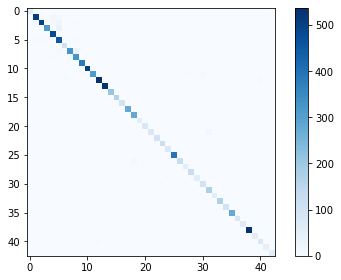

/tmp/ipykernel_5169/1423096600.py:32: RuntimeWarning: divide by zero encountered in log2
  plt.imshow(np.log2(cm-1), interpolation = 'nearest', cmap = plt.get_cmap("tab20"))
/tmp/ipykernel_5169/1423096600.py:32: RuntimeWarning: invalid value encountered in log2
  plt.imshow(np.log2(cm-1), interpolation = 'nearest', cmap = plt.get_cmap("tab20"))


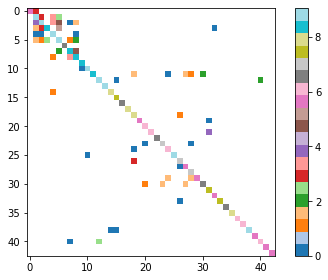

In [15]:
tf.compat.v1.disable_eager_execution()
train_model(X_train, Y_train, X_test, Y_test, 0.001,10,256)

As you can see, we managed to reach a precision of 0.96 on the test set; also, recall and f1 score have the same score. The model looks stable since the loss in the test set is similar to the one reported in the last iteration; therefore, we're not over-fitting nor under-fitting.